In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from datetime import datetime

In [96]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# He initialisation
he_init = tf.variance_scaling_initializer()

def log_dir(prefix=""):
    """Create a unique directory to save model to."""
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "./models"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

# Prepare Data

The <a href="https://arxiv.org/pdf/1812.01718.pdf">Kuzushiji-MNIST (KMNIST) dataset</a> is a drop-in replacement for the MNIST dataset (70,000 28x28 grayscale images across 10 balanced classes of Japanese Hiragana characters).

In [4]:
X_train = np.load("./Kuzushiji-MNIST/kmnist-train-imgs.npz")['arr_0']
y_train = np.load("./Kuzushiji-MNIST/kmnist-train-labels.npz")['arr_0']

X_test = np.load("./Kuzushiji-MNIST/kmnist-test-imgs.npz")['arr_0']
y_test = np.load("./Kuzushiji-MNIST/kmnist-test-labels.npz")['arr_0']

In [5]:
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)

X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_test = y_test.astype(np.int32)

X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

Plot examples of the Hiragana characters.

In [85]:
chars = pd.read_csv("./Kuzushiji-MNIST/kmnist_classmap.csv", index_col='index')
chars

,codepoint,char
index,,
0,U+304A,お
1,U+304D,き
2,U+3059,す
3,U+3064,つ
4,U+306A,な
5,U+306F,は
6,U+307E,ま
7,U+3084,や
8,U+308C,れ


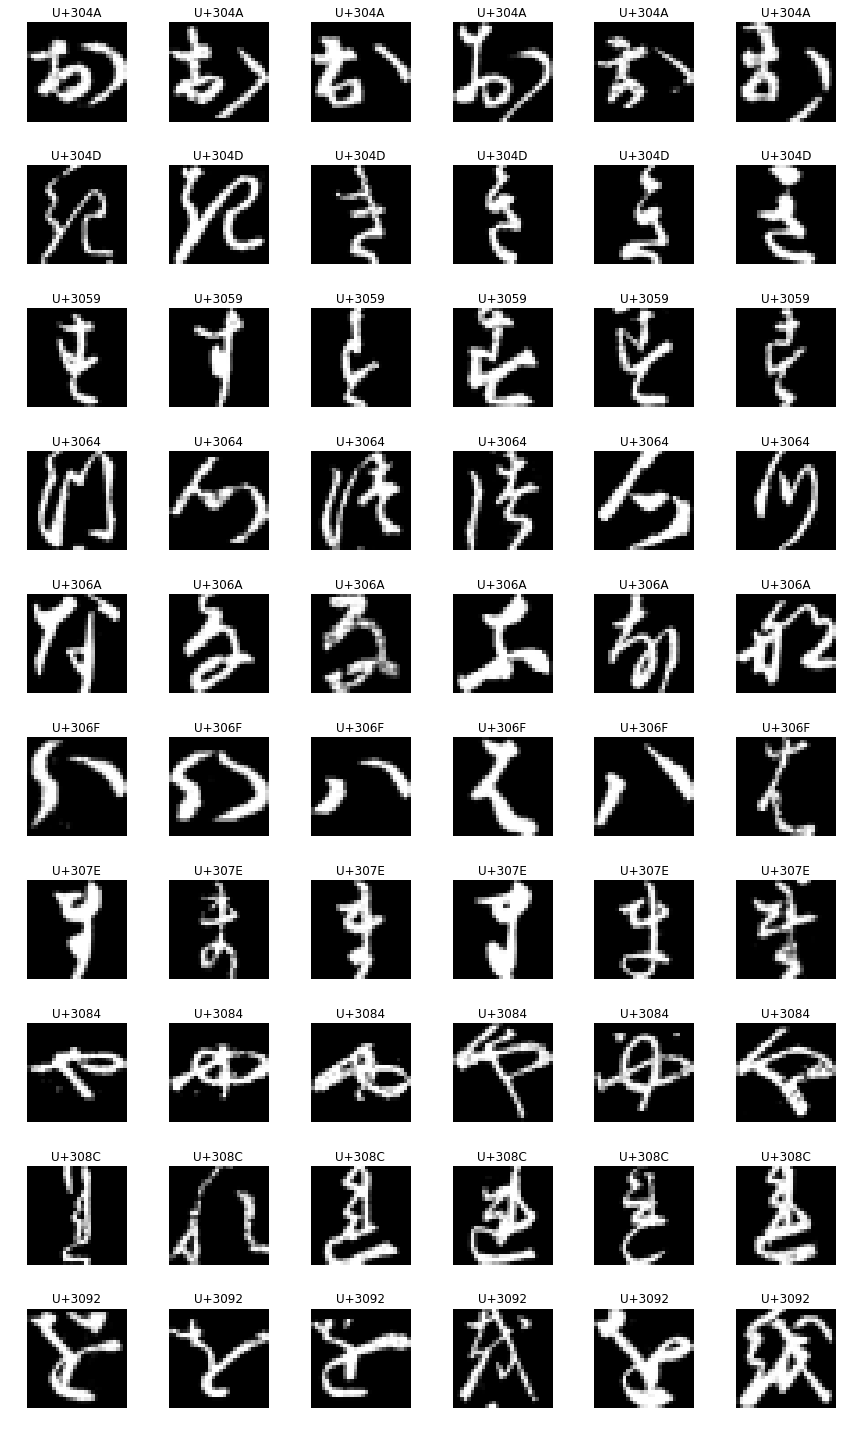

In [84]:
fig, ax = plt.subplots(10, 6, figsize=(12, 20))
for row in range(10):
    label = row
    X = X_train[y_train == label]
    y = y_train[y_train == label]
    for col in range(6):
        ax[row][col].imshow(X[col].reshape(28, 28), cmap='gray')
        ax[row][col].set_title(row)
        ax[row][col].axis('off')
plt.tight_layout()

# Prepare DNN Classifier

Create a class for a configurable DNN classifier. This is a modified version of code borrowed from <a href="https://github.com/ageron/handson-ml">Hands-on Machine Learning with Scikit-Learn and TensorFlow</a>.

In [107]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None, random_state=None, run_name=""):
        """Initialize the DNNClassifier by simply storing all the hyperparameters."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self.run_name = run_name
        self._session = None

    def _dnn(self, inputs):
        """Build the hidden layers, with support for batch normalization and dropout."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="hidden%d" % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs

    def _build_graph(self, n_inputs, n_outputs):
        """Build the same model as earlier"""
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)

        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")

        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None

        dnn_outputs = self._dnn(X)

        logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                                  logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")
        loss_summary = tf.summary.scalar("log_loss", loss)

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)

        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        accuracy_summary = tf.summary.scalar("accuracy", accuracy)

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        # Make the important operations available easily through instance variables
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._loss_summary, self._accuracy_summary = loss_summary, accuracy_summary
        self._init, self._saver = init, saver

    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_params(self):
        """Get all variable values (used for early stopping, faster than saving to disk)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}

    def _restore_model_params(self, model_params):
        """Set all variables to the given values (for early stopping, faster than loading from disk)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)

    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        """Fit the model to the training set. If X_valid and y_valid are provided, use early stopping."""
        self.close_session()

        # infer n_inputs and n_outputs from the training set.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        
        # Translate the labels vector to a vector of sorted class indices, containing
        # integers from 0 to n_outputs - 1.
        # For example, if y is equal to [8, 8, 9, 5, 7, 6, 6, 6], then the sorted class
        # labels (self.classes_) will be equal to [5, 6, 7, 8, 9], and the labels vector
        # will be translated to [3, 3, 4, 0, 2, 1, 1, 1]
        self.class_to_index_ = {label: index
                                for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)
            logdir = log_dir(self.run_name)
            file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
            # extra ops for batch normalization
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        # needed in case of early stopping
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None
        
        # Now train the model!
        self._session = tf.Session(graph=self._graph, config=config)
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val, loss_str, acc_str = sess.run(
                        [self._loss, self._accuracy, self._loss_summary, self._accuracy_summary],
                         feed_dict={self._X: X_valid, self._y: y_valid})
                    file_writer.add_summary(loss_str, epoch)
                    file_writer.add_summary(acc_str, epoch)
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print("Early stopping!")
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy],
                                                     feed_dict={self._X: X_batch,
                                                                self._y: y_batch})
                    print("{}\tLast training batch loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_train, acc_train * 100))
            # If we used early stopping then rollback to the best model found
            if best_params:
                self._restore_model_params(best_params)
            save_path = self._saver.save(sess, logdir + "model.ckpt")
            return self

    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("This %s instance is not fitted yet" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})

    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)

# DNN Architecture

Evaluate the performance of various DNN architectures.

In [130]:
layers = [(3, 50), (4, 50), (5, 50), (6, 50),
          (3, 100), (4, 100), (5, 100), (6, 100),
          (3, 200), (4, 200), (5, 200), (6, 200)]

In [131]:
from sklearn.metrics import accuracy_score
from IPython.display import clear_output

layer_scores = {}

for layer in layers:
    clear_output() # Clear output between runs
    name = "%sx%s" % (layer[0], layer[1])
    print("Running %s architecture..." % name)
    dnn_clf = DNNClassifier(learning_rate=0.001, n_hidden_layers=layer[0], n_neurons=layer[1], run_name=name)
    dnn_clf.fit(X_train, y_train, n_epochs=1000, X_valid=X_valid, y_valid=y_valid)
    y_pred = dnn_clf.predict(X_test)
    layer_scores[name] = accuracy_score(y_test, y_pred) * 100
    
print("\n", layer_scores)

Running 6x200 architecture...
0	Validation loss: 0.319094	Best loss: 0.319094	Accuracy: 90.70%
1	Validation loss: 0.246244	Best loss: 0.246244	Accuracy: 92.86%
2	Validation loss: 0.211677	Best loss: 0.211677	Accuracy: 94.12%
3	Validation loss: 0.198361	Best loss: 0.198361	Accuracy: 94.84%
4	Validation loss: 0.225758	Best loss: 0.198361	Accuracy: 94.42%
5	Validation loss: 0.220183	Best loss: 0.198361	Accuracy: 94.76%
6	Validation loss: 0.216530	Best loss: 0.198361	Accuracy: 94.92%
7	Validation loss: 0.205597	Best loss: 0.198361	Accuracy: 96.04%
8	Validation loss: 0.188339	Best loss: 0.188339	Accuracy: 95.54%
9	Validation loss: 0.218043	Best loss: 0.188339	Accuracy: 95.32%
10	Validation loss: 0.257718	Best loss: 0.188339	Accuracy: 94.74%
11	Validation loss: 0.220529	Best loss: 0.188339	Accuracy: 95.40%
12	Validation loss: 0.219144	Best loss: 0.188339	Accuracy: 95.84%
13	Validation loss: 0.242729	Best loss: 0.188339	Accuracy: 95.62%
14	Validation loss: 1.492876	Best loss: 0.188339	Accurac

# Optimisers

Evaluate the performance of various optimisers.

In [118]:
from functools import partial

momentum = partial(tf.train.MomentumOptimizer, momentum=0.9)
nesterov = partial(tf.train.MomentumOptimizer, momentum=0.9, use_nesterov=True)
rmsprop = partial(tf.train.RMSPropOptimizer, momentum=0.9, decay=0.9, epsilon=1e-10)

optimisers = [tf.train.GradientDescentOptimizer, momentum, nesterov, rmsprop,
              tf.train.AdagradOptimizer, tf.train.AdamOptimizer]
opt_names = ['GD', 'momentum', 'nesterov', 'RMSProp', 'Adagrad', 'Adam']

In [122]:
optimiser_scores = {}

for optimiser, name in zip(optimisers, opt_names):
    clear_output() # Clear output between runs
    print("Running %s optimiser..." % name)
    dnn_clf = DNNClassifier(learning_rate=0.001, optimizer_class=optimiser, run_name=name)
    dnn_clf.fit(X_train, y_train, n_epochs=1000, X_valid=X_valid, y_valid=y_valid)
    y_pred = dnn_clf.predict(X_test)
    optimiser_scores[name] = accuracy_score(y_test, y_pred) * 100
    
print("\n", optimiser_scores)

# Activation Functions

Evaluate the performance of various activation functions.

In [135]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * tf.where(z >= 0.0, z, alpha * tf.nn.elu(z))

In [136]:
act_funcs = [tf.nn.relu, leaky_relu, tf.nn.elu, selu]
act_names = ['ReLU', 'leaky_ReLU', 'ELU', 'SELU']

In [140]:
act_func_scores = {}

for act_func, name in zip(act_funcs, act_names):
    clear_output() # Clear output between runs
    print("Running %s activation function..." % name)
    dnn_clf = DNNClassifier(learning_rate=0.001, optimizer_class=tf.train.GradientDescentOptimizer,
                            activation=act_func, run_name=name)
    dnn_clf.fit(X_train, y_train, n_epochs=1000, X_valid=X_valid, y_valid=y_valid)
    y_pred = dnn_clf.predict(X_test)
    act_func_scores[name] = accuracy_score(y_test, y_pred) * 100
    
print("\n", act_func_scores)

Running ReLU activation function...
0	Validation loss: 2.219605	Best loss: 2.219605	Accuracy: 23.96%
1	Validation loss: 1.563851	Best loss: 1.563851	Accuracy: 54.18%
2	Validation loss: 0.988675	Best loss: 0.988675	Accuracy: 70.68%
3	Validation loss: 0.756414	Best loss: 0.756414	Accuracy: 76.46%
4	Validation loss: 0.651011	Best loss: 0.651011	Accuracy: 80.02%
5	Validation loss: 0.576669	Best loss: 0.576669	Accuracy: 82.70%
6	Validation loss: 0.523973	Best loss: 0.523973	Accuracy: 84.96%
7	Validation loss: 0.485433	Best loss: 0.485433	Accuracy: 85.62%
8	Validation loss: 0.452170	Best loss: 0.452170	Accuracy: 86.34%
9	Validation loss: 0.427356	Best loss: 0.427356	Accuracy: 87.38%
10	Validation loss: 0.401905	Best loss: 0.401905	Accuracy: 88.04%
11	Validation loss: 0.380035	Best loss: 0.380035	Accuracy: 88.72%
12	Validation loss: 0.380103	Best loss: 0.380035	Accuracy: 88.62%
13	Validation loss: 0.350050	Best loss: 0.350050	Accuracy: 89.66%
14	Validation loss: 0.340904	Best loss: 0.340904	A

KeyboardInterrupt: 

# Learning Rates

Evaluate the performance of various learning rates.

In [158]:
# Higher learning rates return errors
learning_rates = [0.001, 0.01, 0.1]

In [159]:
lr_scores = {}

for rate in learning_rates:
    clear_output() # Clear output between runs
    name = "lr_%s" % str(rate).replace(".", "_")
    print("Running %s..." % name)
    dnn_clf = DNNClassifier(learning_rate=rate, optimizer_class=tf.train.GradientDescentOptimizer, run_name=name)
    dnn_clf.fit(X_train, y_train, n_epochs=1000, X_valid=X_valid, y_valid=y_valid)
    y_pred = dnn_clf.predict(X_test)
    lr_scores[name] = accuracy_score(y_test, y_pred) * 100
    
print("\n", lr_scores)

Running lr_0_2...
0	Validation loss: 0.308161	Best loss: 0.308161	Accuracy: 91.26%
1	Validation loss: 0.224185	Best loss: 0.224185	Accuracy: 93.20%
2	Validation loss: 0.238571	Best loss: 0.224185	Accuracy: 93.06%
3	Validation loss: 0.197386	Best loss: 0.197386	Accuracy: 94.82%
4	Validation loss: 0.214893	Best loss: 0.197386	Accuracy: 94.28%
5	Validation loss: 0.191503	Best loss: 0.191503	Accuracy: 94.96%


KeyboardInterrupt: 

# Batch Normalised Momentum

Evaluate the performance when using batch normalised momentum.

In [163]:
bnms = [None, 0.3, 0.6, 0.9]

In [166]:
bnm_scores = {}

for bnm in bnms:
    clear_output() # Clear output between runs
    name = "bnm_%s" % str(bnm).replace(".", "_")
    print("Running %s..." % name)
    dnn_clf = DNNClassifier(learning_rate=0.001, optimizer_class=tf.train.GradientDescentOptimizer,
                            batch_norm_momentum=bnm, run_name=name)
    dnn_clf.fit(X_train, y_train, n_epochs=1000, X_valid=X_valid, y_valid=y_valid)
    y_pred = dnn_clf.predict(X_test)
    bnm_scores[name] = accuracy_score(y_test, y_pred) * 100
    
print("\n", bnm_scores)

Running bnm_0_9...
0	Validation loss: 0.687955	Best loss: 0.687955	Accuracy: 79.68%
1	Validation loss: 0.540331	Best loss: 0.540331	Accuracy: 84.00%


KeyboardInterrupt: 

# Dropout

Evaluate the performance when using drop out.

In [173]:
dropouts = [None, 0.1, 0.3, 0.5]

In [174]:
dropout_scores = {}

for dropout in dropouts[3:]:
    clear_output() # Clear output between runs
    name = "dropout_%s" % str(dropout).replace(".", "_")
    print("Running %s..." % name)
    dnn_clf = DNNClassifier(learning_rate=0.001, optimizer_class=tf.train.GradientDescentOptimizer,
                            dropout_rate=dropout, run_name=name)
    dnn_clf.fit(X_train, y_train, n_epochs=1000, X_valid=X_valid, y_valid=y_valid)
    y_pred = dnn_clf.predict(X_test)
    bnm_scores[name] = accuracy_score(y_test, y_pred) * 100
    
print("\n", dropout_scores)

Running dropout_0_5...
0	Validation loss: 1.787850	Best loss: 1.787850	Accuracy: 43.48%
1	Validation loss: 1.483491	Best loss: 1.483491	Accuracy: 53.20%
2	Validation loss: 1.285339	Best loss: 1.285339	Accuracy: 59.52%
3	Validation loss: 1.146643	Best loss: 1.146643	Accuracy: 64.12%
4	Validation loss: 1.046341	Best loss: 1.046341	Accuracy: 67.58%
5	Validation loss: 0.973883	Best loss: 0.973883	Accuracy: 69.86%


KeyboardInterrupt: 